<a href="https://colab.research.google.com/github/aziz0519/Python-Programs/blob/master/NLP_and_predictive_analytics_of_blockchain_whitepapers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount drive

from google.colab import drive
from google.colab import files 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#essential libraries
import random
import datetime
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
#import stats libraries
from scipy.stats import skew,norm  
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p
from scipy.stats import pearsonr
import scipy.stats as st
import statsmodels.api as sm

In [4]:
#load data
data = pd.read_json(r"/content/drive/My Drive/df.json",orient='colunms')
data.head()

,coin,text,length,coin_id,first_date,first_price,latest_date [9/9/19],latest_price,price_change,price_drop_true
0,0chain,The 0Chain Consensus Protocol\n\nJonathan Katz...,3978,0chain,19/07/2018,0.483325,09/09/2019,0.037275,-0.446050,1
1,0x,0x: An open protocol for decentralized exchang...,5269,0x,17/10/2017,0.220802,09/09/2019,0.161849,-0.058953,1
2,0xcert,\n\n \n \n0xcert protocol \nWhitepaper 0.6 \n...,13563,0xcert,12/07/2018,0.043637,09/09/2019,0.001059,-0.042578,1
3,1irstcoin,\n \n \n \n \n \n \n\n \n\n \n\n \n\n \n\n \n...,1340,1irstcoin,28/02/2019,5.741111,09/09/2019,3.430866,-2.310245,1
4,1World,\n\n \n\n \n\n \n\nLegal​ ​Disclaimer \n\n \...,10449,1world,23/03/2018,0.284330,09/09/2019,0.020668,-0.263662,1


In [5]:
data.shape

(884, 10)

In [6]:
def tsplit(s,sep):
  stack = [s]
  for char in sep:
    pieces = []
    for substr in stack:
      pieces.extend(substr.split(char))
      stack = pieces
  return stack

first_text = data['text'][0]
first_text

'The 0Chain Consensus Protocol\n\nJonathan Katz1(cid:63), Thomas Austin2, Siva Dirisala3, and Saswata Basu3\n\n1 Dept. of Computer Science, University of Maryland.\n\n2 0Chain LLC and San Jose State University.\n\n3 0Chain LLC.\n\nAbstract. We describe the 0Chain blockchain ecosystem, including a\nnew consensus protocol oﬀering fast ﬁnality. We provide proofs of security\nfor the protocol, along with experiment results validating its eﬃciency\nunder realistic network conditions.\n\n1\n\nIntroduction\n\nSince the advent of Bitcoin [Nak09], the blockchain has revolutionized the world\nof cryptocurrencies and distributed computation. Ethereum [Woo14] further de-\nveloped this promise by integrating Turing-complete smart contracts into the\nblockchain for building distributed applications (dApps).\n\nDespite the promise of blockchain protocols, they have been held back by\ntheir slow consensus times. For example, in Bitcoin a transaction is not con-\nsidered ﬁnalized until it is six blocks

In [7]:
clean_text = []
clean_text_length = []

for text in data['text']:
  split_text = tsplit(text, (" ","\n","-\n","\t","\r","\u2000","\u200b","cid:","\xa0","\x0c", "(", ")"))
  split_text = [i for i in split_text if i != '']
  clean_text.append(split_text)
  clean_text_length.append(len(split_text))
  
len(clean_text)

884

In [8]:
data['clean_text'] = clean_text
data['clean_text_length'] = clean_text_length
data.head()

,coin,text,length,coin_id,first_date,first_price,latest_date [9/9/19],latest_price,price_change,price_drop_true,clean_text,clean_text_length
0,0chain,The 0Chain Consensus Protocol\n\nJonathan Katz...,3978,0chain,19/07/2018,0.483325,09/09/2019,0.037275,-0.446050,1,"[The, 0Chain, Consensus, Protocol, Jonathan, K...",4004
1,0x,0x: An open protocol for decentralized exchang...,5269,0x,17/10/2017,0.220802,09/09/2019,0.161849,-0.058953,1,"[0x:, An, open, protocol, for, decentralized, ...",5289
2,0xcert,\n\n \n \n0xcert protocol \nWhitepaper 0.6 \n...,13563,0xcert,12/07/2018,0.043637,09/09/2019,0.001059,-0.042578,1,"[0xcert, protocol, Whitepaper, 0.6, Authors:, ...",13605
3,1irstcoin,\n \n \n \n \n \n \n\n \n\n \n\n \n\n \n\n \n...,1340,1irstcoin,28/02/2019,5.741111,09/09/2019,3.430866,-2.310245,1,"[General, Information, -, Whitepaper, as, of, ...",1340
4,1World,\n\n \n\n \n\n \n\nLegal​ ​Disclaimer \n\n \...,10449,1world,23/03/2018,0.284330,09/09/2019,0.020668,-0.263662,1,"[Legal, Disclaimer, The, purpose, of, this, Wh...",10409


In [9]:
!pip install textstat

     |████████████████████████████████| 3.0MB 4.2MB/s 


In [0]:
import textstat
from itertools import groupby
from string import punctuation

In [11]:
def retrieve_str(x):
  if len(x) == 0:
    return ''
  else:
    return ' '.join(x)
  
#Clean text and remove punctuation

def remove_dup_punc(x):
  new_text = []
  for k,g in groupby(x):
    if k in set(punctuation):
      new_text.append(k)
    else:
      new_text.extend(g)
  return ' '.join(new_text)

#create new column
data = data.sort_index()
data['clean_text2'] = data['clean_text'].apply(remove_dup_punc)
data['readability'] = data['clean_text2'].apply(textstat.flesch_reading_ease)

data.head()

,coin,text,length,coin_id,first_date,first_price,latest_date [9/9/19],latest_price,price_change,price_drop_true,clean_text,clean_text_length,clean_text2,readability
0,0chain,The 0Chain Consensus Protocol\n\nJonathan Katz...,3978,0chain,19/07/2018,0.483325,09/09/2019,0.037275,-0.446050,1,"[The, 0Chain, Consensus, Protocol, Jonathan, K...",4004,The 0Chain Consensus Protocol Jonathan Katz1 6...,54.86
1,0x,0x: An open protocol for decentralized exchang...,5269,0x,17/10/2017,0.220802,09/09/2019,0.161849,-0.058953,1,"[0x:, An, open, protocol, for, decentralized, ...",5289,0x: An open protocol for decentralized exchang...,38.15
2,0xcert,\n\n \n \n0xcert protocol \nWhitepaper 0.6 \n...,13563,0xcert,12/07/2018,0.043637,09/09/2019,0.001059,-0.042578,1,"[0xcert, protocol, Whitepaper, 0.6, Authors:, ...",13605,0xcert protocol Whitepaper 0.6 Authors: Kristi...,36.02
3,1irstcoin,\n \n \n \n \n \n \n\n \n\n \n\n \n\n \n\n \n...,1340,1irstcoin,28/02/2019,5.741111,09/09/2019,3.430866,-2.310245,1,"[General, Information, -, Whitepaper, as, of, ...",1340,General Information - Whitepaper as of July 20...,47.72
4,1World,\n\n \n\n \n\n \n\nLegal​ ​Disclaimer \n\n \...,10449,1world,23/03/2018,0.284330,09/09/2019,0.020668,-0.263662,1,"[Legal, Disclaimer, The, purpose, of, this, Wh...",10409,Legal Disclaimer The purpose of this White Pap...,14.50


In [12]:
data['readability'].describe()

count      884.000000
mean       -19.436312
std        802.733444
min     -21099.390000
25%         32.312500
50%         38.660000
75%         46.325000
max        206.840000
Name: readability, dtype: float64

In [13]:
data[(data.readability <= 30.0)]

,coin,text,length,coin_id,first_date,first_price,latest_date [9/9/19],latest_price,price_change,price_drop_true,clean_text,clean_text_length,clean_text2,readability
4,1World,\n\n \n\n \n\n \n\nLegal​ ​Disclaimer \n\n \...,10449,1world,23/03/2018,0.284330,09/09/2019,0.020668,-0.263662,1,"[Legal, Disclaimer, The, purpose, of, this, Wh...",10409,Legal Disclaimer The purpose of this White Pap...,14.50
6,ABCC Token,Index \n\nOur Vision\t\n1. Background\t\n\n1....,3067,abcc-token,26/07/2018,0.636297,09/09/2019,0.043292,-0.593005,1,"[Index, Our, Vision, 1., Background, 1.1, Oppo...",3069,Index Our Vision 1. Background 1.1 Opportuniti...,28.37
16,Aditus,\n \n \n \n \n \n \n \n \n \n \n\n \n\nAditus...,10215,aditus,19/04/2018,0.023010,09/09/2019,0.000879,-0.022131,1,"[Aditus, Luxury, Access, Platform, for, Crypto...",10237,Aditus Luxury Access Platform for Crypto-Afflu...,20.08
22,Aeron,Blockchain for Airline Passengers Safety\n\nBl...,6411,aeron,10/11/2017,0.262370,09/09/2019,0.173098,-0.089271,1,"[Blockchain, for, Airline, Passengers, Safety,...",6417,Blockchain for Airline Passengers Safety Block...,29.93
25,AI Doctor,\n\n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,10331,ai-doctor,15/02/2018,0.073827,09/09/2019,0.003789,-0.070037,1,"[AIDOC, AIdoctor, on, the, Blockchain, v.0.777...",10337,AIDOC AIdoctor on the Blockchain v.0.777777 WW...,25.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,Xaurum,Join the rise of a digital asset with \ncontin...,10511,xaurum,21/04/2015,52.996700,09/09/2019,0.032978,-52.963722,1,"[Join, the, rise, of, a, digital, asset, with,...",10574,Join the rise of a digital asset with continuo...,29.96
865,XTRD,13/07/2018Version 1.5WHITE PAPERVERSION 1.53/0...,10098,xtrade,04/08/2018,0.006612,08/09/2019,0.001130,-0.005482,1,"[13/07/2018Version, 1.5WHITE, PAPERVERSION, 1....",10142,13/07/2018Version 1.5WHITE PAPERVERSION 1.53/0...,18.52
868,YouLive Coin,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n ...,5602,youlive-coin,17/09/2018,0.000506,09/09/2019,0.000477,-0.000029,1,"[YouLive, Whitepaper, YouLive, Team, Version:,...",5608,YouLive Whitepaper YouLive Team Version: V1.0....,14.90
869,YOYOW,\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n ...,4568,yoyow,06/12/2017,0.328872,09/09/2019,0.012147,-0.316725,1,"[1, Table, Of, Contents, Overview, ..............",4578,1 Table Of Contents Overview ....................,25.12


In [14]:
data.drop(data[data.readability <= 30.0].index, inplace=True)
data.reset_index(drop=True,inplace=True)
data.shape

(713, 14)

In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
def preprocess(text):
  text = text.lower()
  text = re.sub('[^a-zA-Z]+',' ',text)
  words = text.split()
  wnl = WordNetLemmatizer()
  words2 = [wnl.lemmatize(word) for word in words if not word in set(stopwords.words('english'))]
  words3 = ' '.join(words2)
  return words3

In [0]:
data['clean_text3'] = data['clean_text2'].astype(str).apply(preprocess)

In [19]:
data.head()

,coin,text,length,coin_id,first_date,first_price,latest_date [9/9/19],latest_price,price_change,price_drop_true,clean_text,clean_text_length,clean_text2,readability,clean_text3
0,0chain,The 0Chain Consensus Protocol\n\nJonathan Katz...,3978,0chain,19/07/2018,0.483325,09/09/2019,0.037275,-0.446050,1,"[The, 0Chain, Consensus, Protocol, Jonathan, K...",4004,The 0Chain Consensus Protocol Jonathan Katz1 6...,54.86,chain consensus protocol jonathan katz thomas ...
1,0x,0x: An open protocol for decentralized exchang...,5269,0x,17/10/2017,0.220802,09/09/2019,0.161849,-0.058953,1,"[0x:, An, open, protocol, for, decentralized, ...",5289,0x: An open protocol for decentralized exchang...,38.15,x open protocol decentralized exchange ethereu...
2,0xcert,\n\n \n \n0xcert protocol \nWhitepaper 0.6 \n...,13563,0xcert,12/07/2018,0.043637,09/09/2019,0.001059,-0.042578,1,"[0xcert, protocol, Whitepaper, 0.6, Authors:, ...",13605,0xcert protocol Whitepaper 0.6 Authors: Kristi...,36.02,xcert protocol whitepaper author kristijan sed...
3,1irstcoin,\n \n \n \n \n \n \n\n \n\n \n\n \n\n \n\n \n...,1340,1irstcoin,28/02/2019,5.741111,09/09/2019,3.430866,-2.310245,1,"[General, Information, -, Whitepaper, as, of, ...",1340,General Information - Whitepaper as of July 20...,47.72,general information whitepaper july introducti...
4,1x2 Coin,WHITEPAPER\n\n TABLE OF CONTENTS\n\n Introduc...,1907,1x2-coin,31/10/2018,8.511169,09/09/2019,0.088748,-8.422420,1,"[WHITEPAPER, TABLE, OF, CONTENTS, , Introduct...",1910,WHITEPAPER TABLE OF CONTENTS  Introduction In...,32.74,whitepaper table content introduction introduc...


In [20]:
data.columns

Index(['coin', 'text', 'length', 'coin_id', 'first_date', 'first_price',
       'latest_date [9/9/19]', 'latest_price', 'price_change',
       'price_drop_true', 'clean_text', 'clean_text_length', 'clean_text2',
       'readability', 'clean_text3'],
      dtype='object')

In [21]:
data.columns[data.isnull().any()]

Index([], dtype='object')

In [22]:
day_diff = []

for num in range(len(data)):
  date_start = data['first_date'][num]
  date_start_formatted = datetime.datetime.strptime(date_start, "%d/%m/%Y")
  date_end = data['latest_date [9/9/19]'][num]
  date_end_formatted = datetime.datetime.strptime(date_end, "%d/%m/%Y")
  days_diff = date_end_formatted - date_start_formatted
  day_diff.append(days_diff.days)

len(day_diff)
  

713

In [23]:
data['day_diff'] = day_diff
data.head()

,coin,text,length,coin_id,first_date,first_price,latest_date [9/9/19],latest_price,price_change,price_drop_true,clean_text,clean_text_length,clean_text2,readability,clean_text3,day_diff
0,0chain,The 0Chain Consensus Protocol\n\nJonathan Katz...,3978,0chain,19/07/2018,0.483325,09/09/2019,0.037275,-0.446050,1,"[The, 0Chain, Consensus, Protocol, Jonathan, K...",4004,The 0Chain Consensus Protocol Jonathan Katz1 6...,54.86,chain consensus protocol jonathan katz thomas ...,417
1,0x,0x: An open protocol for decentralized exchang...,5269,0x,17/10/2017,0.220802,09/09/2019,0.161849,-0.058953,1,"[0x:, An, open, protocol, for, decentralized, ...",5289,0x: An open protocol for decentralized exchang...,38.15,x open protocol decentralized exchange ethereu...,692
2,0xcert,\n\n \n \n0xcert protocol \nWhitepaper 0.6 \n...,13563,0xcert,12/07/2018,0.043637,09/09/2019,0.001059,-0.042578,1,"[0xcert, protocol, Whitepaper, 0.6, Authors:, ...",13605,0xcert protocol Whitepaper 0.6 Authors: Kristi...,36.02,xcert protocol whitepaper author kristijan sed...,424
3,1irstcoin,\n \n \n \n \n \n \n\n \n\n \n\n \n\n \n\n \n...,1340,1irstcoin,28/02/2019,5.741111,09/09/2019,3.430866,-2.310245,1,"[General, Information, -, Whitepaper, as, of, ...",1340,General Information - Whitepaper as of July 20...,47.72,general information whitepaper july introducti...,193
4,1x2 Coin,WHITEPAPER\n\n TABLE OF CONTENTS\n\n Introduc...,1907,1x2-coin,31/10/2018,8.511169,09/09/2019,0.088748,-8.422420,1,"[WHITEPAPER, TABLE, OF, CONTENTS, , Introduct...",1910,WHITEPAPER TABLE OF CONTENTS  Introduction In...,32.74,whitepaper table content introduction introduc...,313


In [0]:
from wordcloud import WordCloud

In [25]:
long_string = ",".join(list(data['clean_text2'].values))

print(len(long_string))

30800057


In [0]:
from wordcloud import STOPWORDS, ImageColorGenerator

In [0]:
stopwords  = set(STOPWORDS)
stopwords.update(["well","time","use","using","one","based","make","new","provide","white"])

In [0]:
wordcloud = WordCloud(width = 400, height = 300, background_color = "white", max_words = 1000, contour_width = 3 , contour_color= 'steelblue', stopwords = stopwords).generate(long_string) 

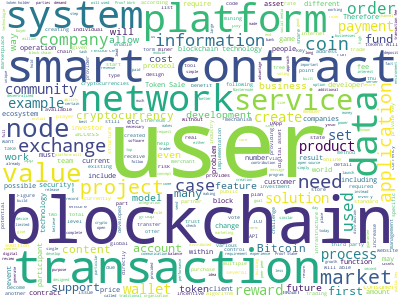

In [29]:
wordcloud.to_image()

In [30]:
list_words = []
list_words_length = []

for i in range(len(data)):
  split_text = data['clean_text3'][i].split()
  list_words.append(split_text)
  list_words_length.append(len(split_text))

len(list_words)

713

In [31]:
data['text_corpus'] = list_words
data['text_corpus_length'] = list_words_length
data.head()

,coin,text,length,coin_id,first_date,first_price,latest_date [9/9/19],latest_price,price_change,price_drop_true,clean_text,clean_text_length,clean_text2,readability,clean_text3,day_diff,text_corpus,text_corpus_length
0,0chain,The 0Chain Consensus Protocol\n\nJonathan Katz...,3978,0chain,19/07/2018,0.483325,09/09/2019,0.037275,-0.446050,1,"[The, 0Chain, Consensus, Protocol, Jonathan, K...",4004,The 0Chain Consensus Protocol Jonathan Katz1 6...,54.86,chain consensus protocol jonathan katz thomas ...,417,"[chain, consensus, protocol, jonathan, katz, t...",2232
1,0x,0x: An open protocol for decentralized exchang...,5269,0x,17/10/2017,0.220802,09/09/2019,0.161849,-0.058953,1,"[0x:, An, open, protocol, for, decentralized, ...",5289,0x: An open protocol for decentralized exchang...,38.15,x open protocol decentralized exchange ethereu...,692,"[x, open, protocol, decentralized, exchange, e...",3036
2,0xcert,\n\n \n \n0xcert protocol \nWhitepaper 0.6 \n...,13563,0xcert,12/07/2018,0.043637,09/09/2019,0.001059,-0.042578,1,"[0xcert, protocol, Whitepaper, 0.6, Authors:, ...",13605,0xcert protocol Whitepaper 0.6 Authors: Kristi...,36.02,xcert protocol whitepaper author kristijan sed...,424,"[xcert, protocol, whitepaper, author, kristija...",8034
3,1irstcoin,\n \n \n \n \n \n \n\n \n\n \n\n \n\n \n\n \n...,1340,1irstcoin,28/02/2019,5.741111,09/09/2019,3.430866,-2.310245,1,"[General, Information, -, Whitepaper, as, of, ...",1340,General Information - Whitepaper as of July 20...,47.72,general information whitepaper july introducti...,193,"[general, information, whitepaper, july, intro...",760
4,1x2 Coin,WHITEPAPER\n\n TABLE OF CONTENTS\n\n Introduc...,1907,1x2-coin,31/10/2018,8.511169,09/09/2019,0.088748,-8.422420,1,"[WHITEPAPER, TABLE, OF, CONTENTS, , Introduct...",1910,WHITEPAPER TABLE OF CONTENTS  Introduction In...,32.74,whitepaper table content introduction introduc...,313,"[whitepaper, table, content, introduction, int...",920


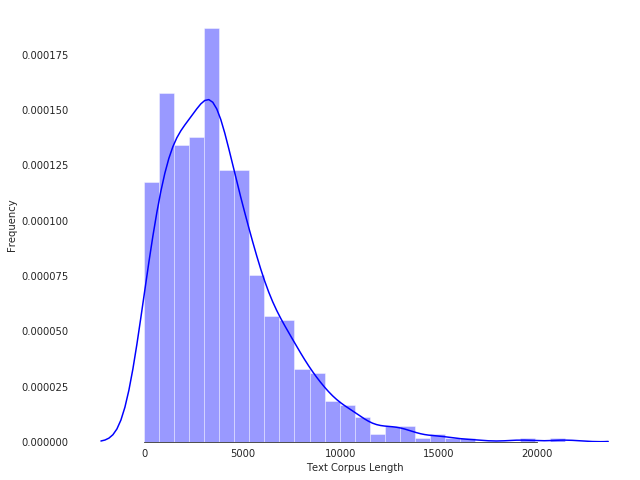

In [32]:
sns.set_style('white')
sns.set_palette('deep')
f, ax = plt.subplots(figsize=(10,8))
sns.distplot(data['text_corpus_length'], color= 'b')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='Text Corpus Length')
sns.despine(trim=True,left=True)
plt.show()

In [0]:
hasToken = []

for cleaned_list in data['text_corpus']:
  if 'token' and 'coin' in [word.lower() for word in cleaned_list]:
    hasToken.append(1)
  else:
    hasToken.append(0)

In [0]:
hasTeamInfo = []

for cleaned_list in data['text_corpus']:
  if 'team' in [word.lower() for word in cleaned_list]:
    hasTeamInfo.append(1)
  else:
    hasTeamInfo.append(0)

In [0]:
hasBlockchain = []

for cleaned_list in data['text_corpus']:
  if 'blockchain' and 'block' in [word.lower() for word in cleaned_list]:
    hasBlockchain.append(1)
  else:
    hasBlockchain.append(0)

In [0]:
hasTransaction = []

for cleaned_list in data['text_corpus']:
  if 'transaction' in [word.lower() for word in cleaned_list]:
    hasTransaction.append(1)
  else:
    hasTransaction.append(0)

In [0]:
hasSmartContract = []

for cleaned_list in data['text_corpus']:
  if 'smart' and 'contract' in [word.lower() for word in cleaned_list]:
    hasSmartContract.append(1)
  else:
    hasSmartContract.append(0)

In [0]:
hasPlatform = []

for cleaned_list in data['text_corpus']:
  if 'platform' in [word.lower() for word in cleaned_list]:
    hasPlatform.append(1)
  else:
    hasPlatform.append(0)

In [0]:
hasData = []

for cleaned_list in data['text_corpus']:
  if 'data' and 'information' in [word.lower() for word in cleaned_list]:
    hasData.append(1)
  else:
    hasData.append(0)

In [0]:
hasUser = []

for cleaned_list in data['text_corpus']:
  if 'user' and 'customer' in [word.lower() for word in cleaned_list]:
    hasUser.append(1)
  else:
    hasUser.append(0)

In [0]:
hasNode =[]

for cleaned_list in data['text_corpus']:
  if 'node' in [word.lower() for word in cleaned_list]:
    hasNode.append(1)
  else:
    hasNode.append(0)

In [0]:
hasNetwork =[]

for cleaned_list in data['text_corpus']:
  if 'network' in [word.lower() for word in cleaned_list]:
    hasNetwork.append(1)
  else:
    hasNetwork.append(0)

In [0]:
hasGame =[]

for cleaned_list in data['text_corpus']:
  if 'game' in [word.lower() for word in cleaned_list]:
    hasGame.append(1)
  else:
    hasGame.append(0)

In [0]:
hasService = []

for cleaned_list in data['text_corpus']:
  if 'service' in [word.lower() for word in cleaned_list]:
    hasService.append(1)
  else:
    hasService.append(0)


In [0]:
hasSystem = []

for cleaned_list in data['text_corpus']:
  if 'system' in [word.lower() for word in cleaned_list]:
    hasSystem.append(1)
  else:
    hasSystem.append(0)

In [0]:
hasTrade = []

for cleaned_list in data['text_corpus']:
  if 'trade' in [word.lower() for word in cleaned_list]:
    hasTrade.append(1)
  else:
    hasTrade.append(0)

In [0]:
hasMining = []

for cleaned_list in data['text_corpus']:
  if 'mining' in [word.lower() for word in cleaned_list]:
    hasMining.append(1)
  else:
    hasMining.append(0)

In [50]:
data['hasToken'] = hasToken
data['hasTeamInfo'] = hasTeamInfo
data['hasBlockchain'] = hasBlockchain
data['hasTransaction'] = hasTransaction
data['hasSmartContract'] = hasSmartContract
data['hasUser'] = hasUser
data['hasData'] = hasData
data['hasPlatform'] = hasPlatform
data['hasNode'] = hasNode
data['hasNetwork'] = hasNetwork
data['hasService'] = hasService
data['hasSystem'] = hasSystem
data['hasTrade'] = hasTrade
data['hasMining'] = hasMining
data['hasGame'] = hasGame
data.head()

,coin,text,length,coin_id,first_date,first_price,latest_date [9/9/19],latest_price,price_change,price_drop_true,clean_text,clean_text_length,clean_text2,readability,clean_text3,day_diff,text_corpus,text_corpus_length,hasToken,hasTeamInfo,hasBlockchain,hasTransaction,hasSmartContract,hasUser,hasData,hasPlatform,hasNode,hasNetwork,hasService,hasSystem,hasTrade,hasMining,hasGame
0,0chain,The 0Chain Consensus Protocol\n\nJonathan Katz...,3978,0chain,19/07/2018,0.483325,09/09/2019,0.037275,-0.446050,1,"[The, 0Chain, Consensus, Protocol, Jonathan, K...",4004,The 0Chain Consensus Protocol Jonathan Katz1 6...,54.86,chain consensus protocol jonathan katz thomas ...,417,"[chain, consensus, protocol, jonathan, katz, t...",2232,1,0,1,1,1,0,0,1,1,1,1,1,0,1,0
1,0x,0x: An open protocol for decentralized exchang...,5269,0x,17/10/2017,0.220802,09/09/2019,0.161849,-0.058953,1,"[0x:, An, open, protocol, for, decentralized, ...",5289,0x: An open protocol for decentralized exchang...,38.15,x open protocol decentralized exchange ethereu...,692,"[x, open, protocol, decentralized, exchange, e...",3036,1,0,1,1,1,1,1,0,1,1,1,1,1,0,1
2,0xcert,\n\n \n \n0xcert protocol \nWhitepaper 0.6 \n...,13563,0xcert,12/07/2018,0.043637,09/09/2019,0.001059,-0.042578,1,"[0xcert, protocol, Whitepaper, 0.6, Authors:, ...",13605,0xcert protocol Whitepaper 0.6 Authors: Kristi...,36.02,xcert protocol whitepaper author kristijan sed...,424,"[xcert, protocol, whitepaper, author, kristija...",8034,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,1irstcoin,\n \n \n \n \n \n \n\n \n\n \n\n \n\n \n\n \n...,1340,1irstcoin,28/02/2019,5.741111,09/09/2019,3.430866,-2.310245,1,"[General, Information, -, Whitepaper, as, of, ...",1340,General Information - Whitepaper as of July 20...,47.72,general information whitepaper july introducti...,193,"[general, information, whitepaper, july, intro...",760,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0
4,1x2 Coin,WHITEPAPER\n\n TABLE OF CONTENTS\n\n Introduc...,1907,1x2-coin,31/10/2018,8.511169,09/09/2019,0.088748,-8.422420,1,"[WHITEPAPER, TABLE, OF, CONTENTS, , Introduct...",1910,WHITEPAPER TABLE OF CONTENTS  Introduction In...,32.74,whitepaper table content introduction introduc...,313,"[whitepaper, table, content, introduction, int...",920,1,1,1,1,0,0,0,1,1,1,1,1,0,1,1


In [0]:
%matplotlib inline
sns.set_style('whitegrid')

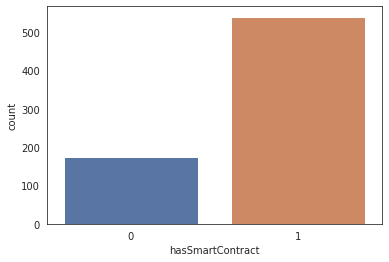

In [51]:
sns.countplot(data['hasSmartContract'])

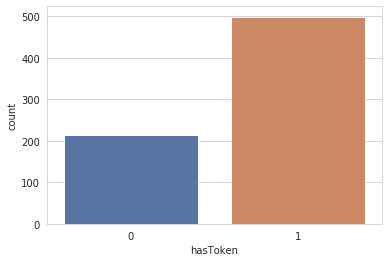

In [53]:
sns.countplot(data['hasToken'])

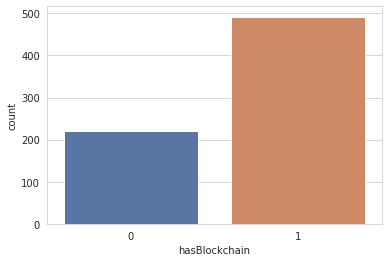

In [54]:
sns.countplot(data['hasBlockchain'])

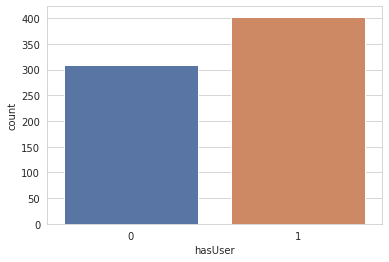

In [56]:
sns.countplot(data['hasUser'])

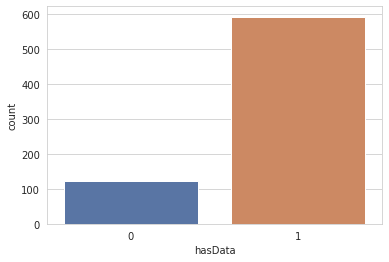

In [57]:
sns.countplot(data['hasData'])

In [0]:
sns.set_style('whitegrid')
sns.set_palette('deep')

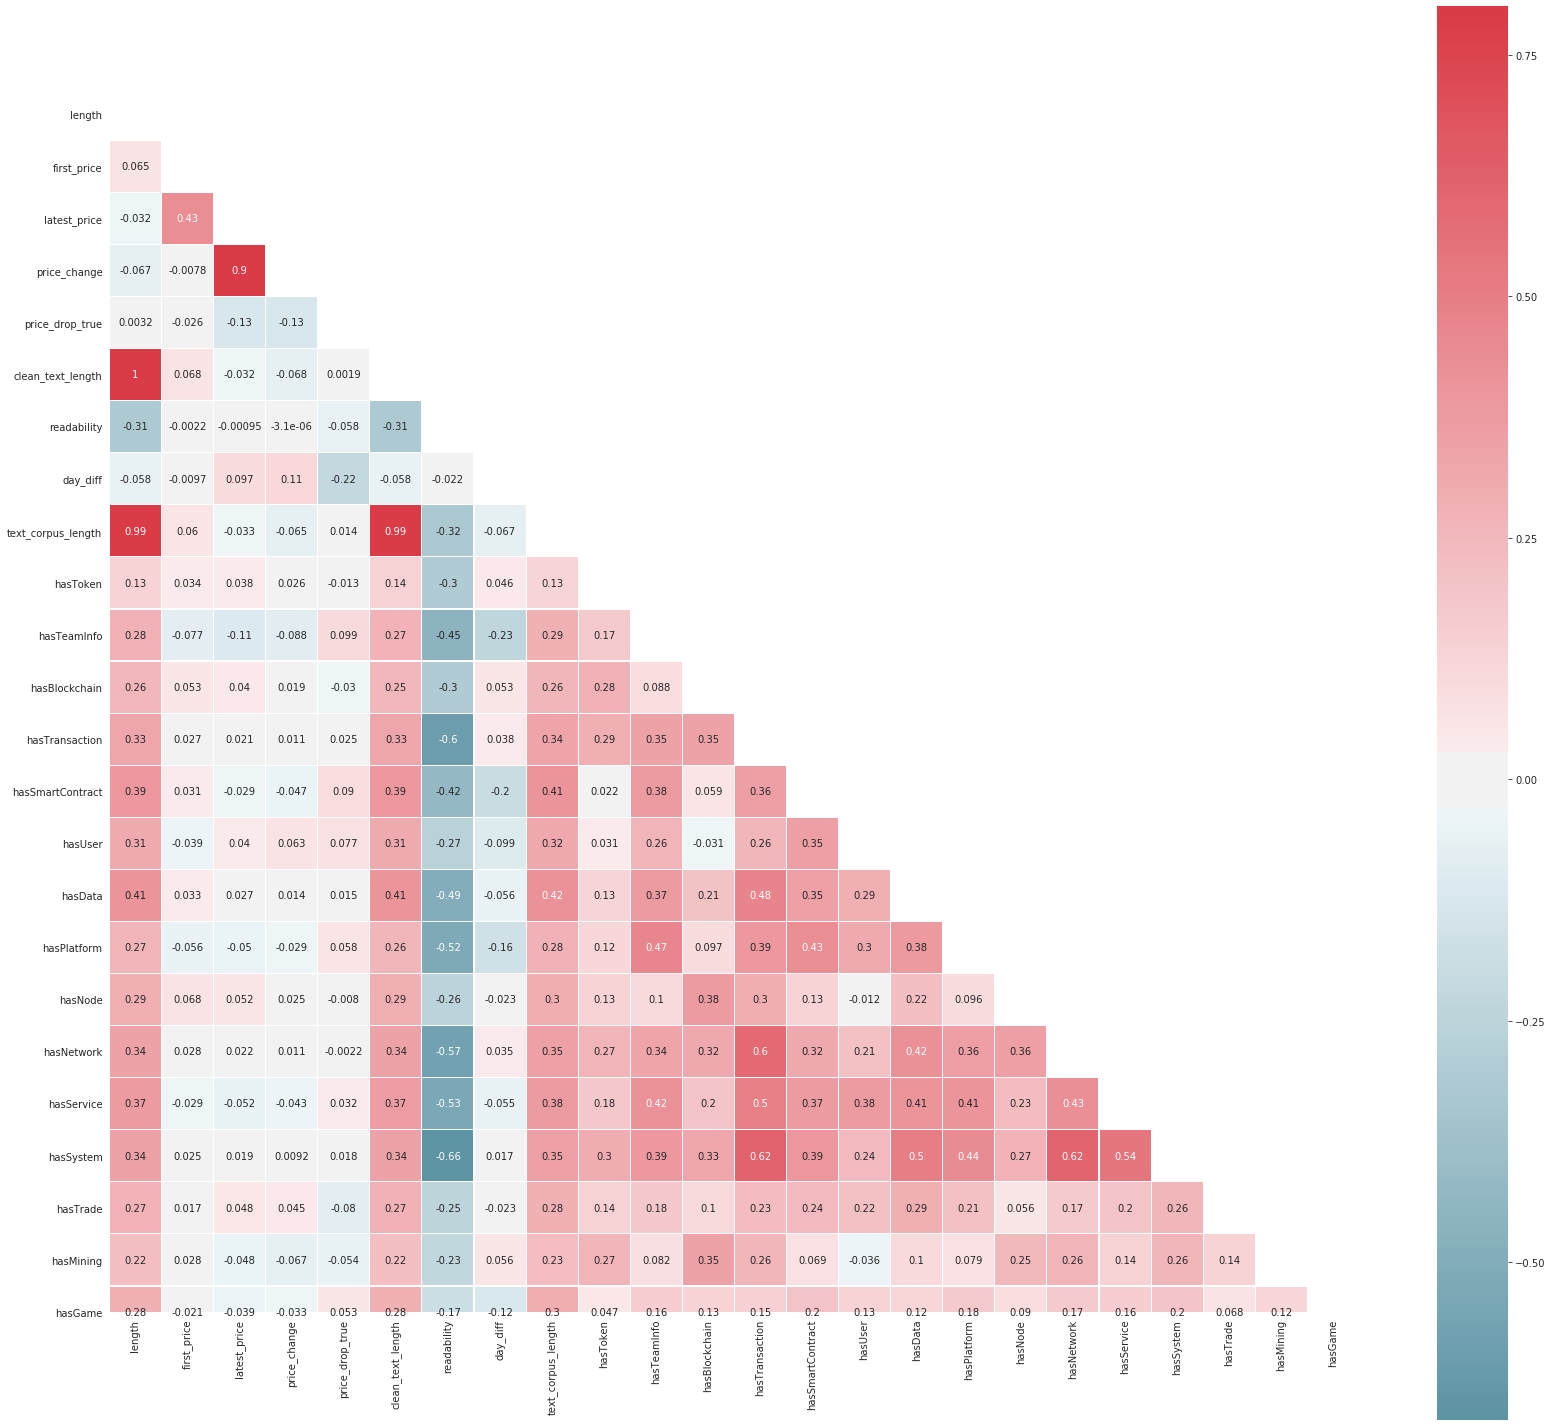

In [59]:
corr = data.corr()

mask = np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize =(28,26))

cmap = sns.diverging_palette(220,10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap , vmax = .8 ,center =0, square=True, annot = True, linewidth = .1)


In [0]:
from textblob import TextBlob

In [0]:
#Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. 
#Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. 
#Subjectivity is also a float which lies in the range of [0,1]

def polarity(x):
  return TextBlob(x).sentiment.polarity

In [62]:
data['polarity_scores'] = data['clean_text2'].apply(polarity)
data.head()

,coin,text,length,coin_id,first_date,first_price,latest_date [9/9/19],latest_price,price_change,price_drop_true,clean_text,clean_text_length,clean_text2,readability,clean_text3,day_diff,text_corpus,text_corpus_length,hasToken,hasTeamInfo,hasBlockchain,hasTransaction,hasSmartContract,hasUser,hasData,hasPlatform,hasNode,hasNetwork,hasService,hasSystem,hasTrade,hasMining,hasGame,polarity_scores
0,0chain,The 0Chain Consensus Protocol\n\nJonathan Katz...,3978,0chain,19/07/2018,0.483325,09/09/2019,0.037275,-0.446050,1,"[The, 0Chain, Consensus, Protocol, Jonathan, K...",4004,The 0Chain Consensus Protocol Jonathan Katz1 6...,54.86,chain consensus protocol jonathan katz thomas ...,417,"[chain, consensus, protocol, jonathan, katz, t...",2232,1,0,1,1,1,0,0,1,1,1,1,1,0,1,0,0.045996
1,0x,0x: An open protocol for decentralized exchang...,5269,0x,17/10/2017,0.220802,09/09/2019,0.161849,-0.058953,1,"[0x:, An, open, protocol, for, decentralized, ...",5289,0x: An open protocol for decentralized exchang...,38.15,x open protocol decentralized exchange ethereu...,692,"[x, open, protocol, decentralized, exchange, e...",3036,1,0,1,1,1,1,1,0,1,1,1,1,1,0,1,0.094660
2,0xcert,\n\n \n \n0xcert protocol \nWhitepaper 0.6 \n...,13563,0xcert,12/07/2018,0.043637,09/09/2019,0.001059,-0.042578,1,"[0xcert, protocol, Whitepaper, 0.6, Authors:, ...",13605,0xcert protocol Whitepaper 0.6 Authors: Kristi...,36.02,xcert protocol whitepaper author kristijan sed...,424,"[xcert, protocol, whitepaper, author, kristija...",8034,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.120486
3,1irstcoin,\n \n \n \n \n \n \n\n \n\n \n\n \n\n \n\n \n...,1340,1irstcoin,28/02/2019,5.741111,09/09/2019,3.430866,-2.310245,1,"[General, Information, -, Whitepaper, as, of, ...",1340,General Information - Whitepaper as of July 20...,47.72,general information whitepaper july introducti...,193,"[general, information, whitepaper, july, intro...",760,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,0.139106
4,1x2 Coin,WHITEPAPER\n\n TABLE OF CONTENTS\n\n Introduc...,1907,1x2-coin,31/10/2018,8.511169,09/09/2019,0.088748,-8.422420,1,"[WHITEPAPER, TABLE, OF, CONTENTS, , Introduct...",1910,WHITEPAPER TABLE OF CONTENTS  Introduction In...,32.74,whitepaper table content introduction introduc...,313,"[whitepaper, table, content, introduction, int...",920,1,1,1,1,0,0,0,1,1,1,1,1,0,1,1,0.117985


In [63]:
data['polarity_scores'].describe()

count    713.000000
mean       0.104026
std        0.045584
min       -0.005812
25%        0.083977
50%        0.105707
75%        0.126411
max        0.666667
Name: polarity_scores, dtype: float64

In [0]:
def subjectivity(x):
  return TextBlob(x).sentiment.subjectivity

In [65]:
data['subjectivity_scores'] = data['clean_text2'].apply(subjectivity)
data.head()

,coin,text,length,coin_id,first_date,first_price,latest_date [9/9/19],latest_price,price_change,price_drop_true,clean_text,clean_text_length,clean_text2,readability,clean_text3,day_diff,text_corpus,text_corpus_length,hasToken,hasTeamInfo,hasBlockchain,hasTransaction,hasSmartContract,hasUser,hasData,hasPlatform,hasNode,hasNetwork,hasService,hasSystem,hasTrade,hasMining,hasGame,polarity_scores,subjectivity_scores
0,0chain,The 0Chain Consensus Protocol\n\nJonathan Katz...,3978,0chain,19/07/2018,0.483325,09/09/2019,0.037275,-0.446050,1,"[The, 0Chain, Consensus, Protocol, Jonathan, K...",4004,The 0Chain Consensus Protocol Jonathan Katz1 6...,54.86,chain consensus protocol jonathan katz thomas ...,417,"[chain, consensus, protocol, jonathan, katz, t...",2232,1,0,1,1,1,0,0,1,1,1,1,1,0,1,0,0.045996,0.501959
1,0x,0x: An open protocol for decentralized exchang...,5269,0x,17/10/2017,0.220802,09/09/2019,0.161849,-0.058953,1,"[0x:, An, open, protocol, for, decentralized, ...",5289,0x: An open protocol for decentralized exchang...,38.15,x open protocol decentralized exchange ethereu...,692,"[x, open, protocol, decentralized, exchange, e...",3036,1,0,1,1,1,1,1,0,1,1,1,1,1,0,1,0.094660,0.458596
2,0xcert,\n\n \n \n0xcert protocol \nWhitepaper 0.6 \n...,13563,0xcert,12/07/2018,0.043637,09/09/2019,0.001059,-0.042578,1,"[0xcert, protocol, Whitepaper, 0.6, Authors:, ...",13605,0xcert protocol Whitepaper 0.6 Authors: Kristi...,36.02,xcert protocol whitepaper author kristijan sed...,424,"[xcert, protocol, whitepaper, author, kristija...",8034,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.120486,0.442333
3,1irstcoin,\n \n \n \n \n \n \n\n \n\n \n\n \n\n \n\n \n...,1340,1irstcoin,28/02/2019,5.741111,09/09/2019,3.430866,-2.310245,1,"[General, Information, -, Whitepaper, as, of, ...",1340,General Information - Whitepaper as of July 20...,47.72,general information whitepaper july introducti...,193,"[general, information, whitepaper, july, intro...",760,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,0.139106,0.392216
4,1x2 Coin,WHITEPAPER\n\n TABLE OF CONTENTS\n\n Introduc...,1907,1x2-coin,31/10/2018,8.511169,09/09/2019,0.088748,-8.422420,1,"[WHITEPAPER, TABLE, OF, CONTENTS, , Introduct...",1910,WHITEPAPER TABLE OF CONTENTS  Introduction In...,32.74,whitepaper table content introduction introduc...,313,"[whitepaper, table, content, introduction, int...",920,1,1,1,1,0,0,0,1,1,1,1,1,0,1,1,0.117985,0.407594


In [66]:
data['subjectivity_scores'].describe()

count    713.000000
mean       0.416551
std        0.097253
min        0.000000
25%        0.406527
50%        0.436049
75%        0.456683
max        0.777778
Name: subjectivity_scores, dtype: float64

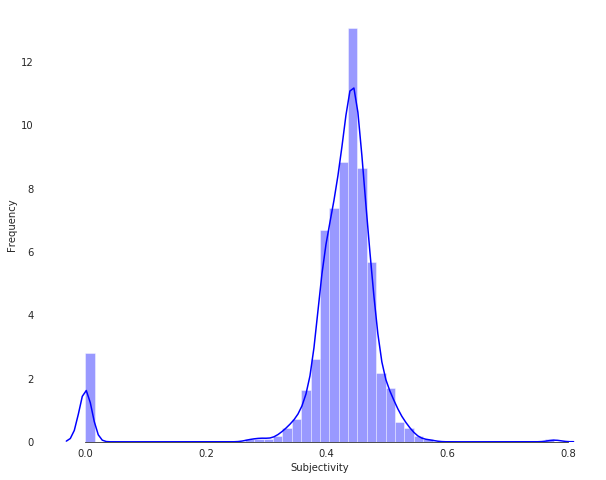

In [67]:
sns.set_style('white')
sns.set_palette('deep')
f, ax = plt.subplots(figsize=(10,8))
sns.distplot(data['subjectivity_scores'], color= 'b')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='Subjectivity')
sns.despine(trim=True,left=True)
plt.show()

In [68]:
data[data.subjectivity_scores <= 0.2]

,coin,text,length,coin_id,first_date,first_price,latest_date [9/9/19],latest_price,price_change,price_drop_true,clean_text,clean_text_length,clean_text2,readability,clean_text3,day_diff,text_corpus,text_corpus_length,hasToken,hasTeamInfo,hasBlockchain,hasTransaction,hasSmartContract,hasUser,hasData,hasPlatform,hasNode,hasNetwork,hasService,hasSystem,hasTrade,hasMining,hasGame,polarity_scores,subjectivity_scores
6,ACChain,,0,acchain,12/02/2018,1.435080,08/09/2019,0.012992,-1.422088,1,[],0,,206.84,,573,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
51,Baer Chain,,0,baer-chain,08/11/2018,0.403360,09/09/2019,2.342941,1.939581,0,[],0,,206.84,,305,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
86,Bitsum,,0,bitsum,20/04/2018,0.001122,08/09/2019,0.000031,-0.001091,1,[],0,,206.84,,506,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
133,Citadel,,0,citadel,09/08/2018,0.024641,08/09/2019,0.001974,-0.022667,1,[],0,,206.84,,395,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
153,Crypto Sports,Whitepaper\n\n1.0\n\n Blockchain Ven...,49,crypto-sports,26/02/2019,0.037911,09/09/2019,0.094435,0.056524,0,"[Whitepaper, 1.0, Blockchain, Venture, Capital...",49,Whitepaper 1.0 Blockchain Venture Capital Fund...,31.22,whitepaper blockchain venture capital funding ...,195,"[whitepaper, blockchain, venture, capital, fun...",32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
161,Crystal Clear-,,0,crystal-clear,28/10/2017,0.511495,09/09/2019,0.003553,-0.507942,1,[],0,,206.84,,681,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
162,Cube,...,0,cube,01/04/2018,0.011705,09/09/2019,0.000961,-0.010744,1,[],0,,206.84,,526,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
198,Dreamcoin,,0,dreamcoin,24/03/2018,0.015556,08/09/2019,0.013116,-0.002439,1,[],0,,206.84,,533,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
206,EDUCare,\n\n \n\n \n\n \n\n \n\n,0,educare,24/01/2018,0.131438,09/09/2019,0.146621,0.015183,0,[],0,,206.84,,593,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0
236,EUNOMIA,\n\n \n\n \n\n \n\n,0,eunomia,23/10/2018,0.000034,08/09/2019,0.000003,-0.000032,1,[],0,,206.84,,320,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0


In [69]:
data[data.clean_text_length < 50]

,coin,text,length,coin_id,first_date,first_price,latest_date [9/9/19],latest_price,price_change,price_drop_true,clean_text,clean_text_length,clean_text2,readability,clean_text3,day_diff,text_corpus,text_corpus_length,hasToken,hasTeamInfo,hasBlockchain,hasTransaction,hasSmartContract,hasUser,hasData,hasPlatform,hasNode,hasNetwork,hasService,hasSystem,hasTrade,hasMining,hasGame,polarity_scores,subjectivity_scores
6,ACChain,,0,acchain,12/02/2018,1.435080,08/09/2019,0.012992,-1.422088,1,[],0,,206.84,,573,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
51,Baer Chain,,0,baer-chain,08/11/2018,0.403360,09/09/2019,2.342941,1.939581,0,[],0,,206.84,,305,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
86,Bitsum,,0,bitsum,20/04/2018,0.001122,08/09/2019,0.000031,-0.001091,1,[],0,,206.84,,506,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
133,Citadel,,0,citadel,09/08/2018,0.024641,08/09/2019,0.001974,-0.022667,1,[],0,,206.84,,395,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
134,Civic,1\n\n Contents\n\n2\n\n 33\n\n 44\n\n 55\n\n 6...,42,civic,30/07/2017,0.163593,09/09/2019,0.040756,-0.122837,1,"[1, Contents, 2, 33, 44, 55, 66, 7, 8, 99, 101...",42,1 Contents 2 33 44 55 66 7 8 99 1010 1111 1212...,46.78,content rewarded token ideally rootstock subje...,771,"[content, rewarded, token, ideally, rootstock,...",13,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.244444,0.777778
153,Crypto Sports,Whitepaper\n\n1.0\n\n Blockchain Ven...,49,crypto-sports,26/02/2019,0.037911,09/09/2019,0.094435,0.056524,0,"[Whitepaper, 1.0, Blockchain, Venture, Capital...",49,Whitepaper 1.0 Blockchain Venture Capital Fund...,31.22,whitepaper blockchain venture capital funding ...,195,"[whitepaper, blockchain, venture, capital, fun...",32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
161,Crystal Clear-,,0,crystal-clear,28/10/2017,0.511495,09/09/2019,0.003553,-0.507942,1,[],0,,206.84,,681,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
162,Cube,...,0,cube,01/04/2018,0.011705,09/09/2019,0.000961,-0.010744,1,[],0,,206.84,,526,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
198,Dreamcoin,,0,dreamcoin,24/03/2018,0.015556,08/09/2019,0.013116,-0.002439,1,[],0,,206.84,,533,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
206,EDUCare,\n\n \n\n \n\n \n\n \n\n,0,educare,24/01/2018,0.131438,09/09/2019,0.146621,0.015183,0,[],0,,206.84,,593,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000


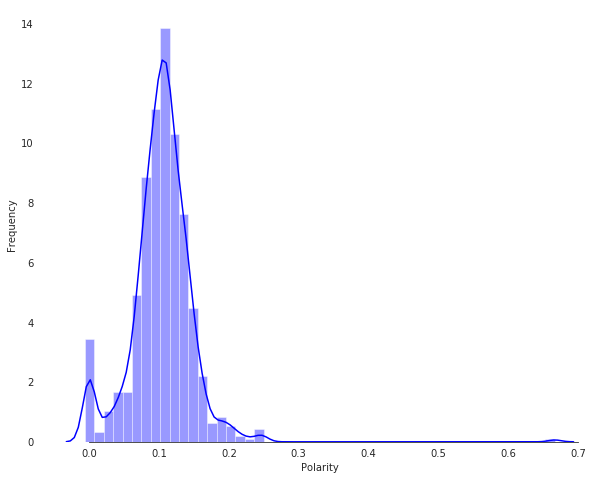

In [70]:
sns.set_style('white')
sns.set_palette('deep')
f, ax = plt.subplots(figsize=(10,8))
sns.distplot(data['polarity_scores'], color= 'b')
ax.xaxis.grid(False)
ax.set(ylabel='Frequency')
ax.set(xlabel='Polarity')
sns.despine(trim=True,left=True)
plt.show()

In [71]:
data['clean_text3'][676]

'hooxi campaign w h e p p e r v w global investment youree lee aug table content abbreviation term introduction executive summary w foundation identity global presence government cooperation hooxi campaign w hy r hanyang university w foundation research institute introduction hanyang university role w hy r background kets korea emission trading scheme carbon market korea carbon credit validation carbon market size w green pay token sale detail allocation hooxi app w green pay distribution funding allocation ghg emission example carbon emission reduction estimated ghg reduction ton per caput per annum revenue projection hooxi app based collected koc w green pay token ecosystem cryptocurrency exchange internet shopping mall credit card krx roadmap strategic partner team reference abbreviation term app mobile application bau business usual cer carbon emission right eu european union ghg greenhouse gas ghg reduction campaign nation wide public movement reduce ghg emission part hooxi campai

In [72]:
data[data.polarity_scores <= 0.0]

,coin,text,length,coin_id,first_date,first_price,latest_date [9/9/19],latest_price,price_change,price_drop_true,clean_text,clean_text_length,clean_text2,readability,clean_text3,day_diff,text_corpus,text_corpus_length,hasToken,hasTeamInfo,hasBlockchain,hasTransaction,hasSmartContract,hasUser,hasData,hasPlatform,hasNode,hasNetwork,hasService,hasSystem,hasTrade,hasMining,hasGame,polarity_scores,subjectivity_scores
6,ACChain,,0,acchain,12/02/2018,1.435080,08/09/2019,0.012992,-1.422088,1,[],0,,206.84,,573,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
9,Achain,\n\nAchain 블록체인 Whitepaper \n\nBuild to be bo...,3962,achain,14/11/2017,0.107318,09/09/2019,0.007289,-0.100028,1,"[Achain, 블록체인, Whitepaper, Build, to, be, boun...",4017,Achain 블록체인 Whitepaper Build to be boundless 목...,46.79,achain whitepaper build boundless achain smart...,664,"[achain, whitepaper, build, boundless, achain,...",452,1,1,0,0,1,0,0,0,0,1,1,1,0,0,0,-0.005812,0.427661
51,Baer Chain,,0,baer-chain,08/11/2018,0.403360,09/09/2019,2.342941,1.939581,0,[],0,,206.84,,305,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
86,Bitsum,,0,bitsum,20/04/2018,0.001122,08/09/2019,0.000031,-0.001091,1,[],0,,206.84,,506,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
133,Citadel,,0,citadel,09/08/2018,0.024641,08/09/2019,0.001974,-0.022667,1,[],0,,206.84,,395,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
153,Crypto Sports,Whitepaper\n\n1.0\n\n Blockchain Ven...,49,crypto-sports,26/02/2019,0.037911,09/09/2019,0.094435,0.056524,0,"[Whitepaper, 1.0, Blockchain, Venture, Capital...",49,Whitepaper 1.0 Blockchain Venture Capital Fund...,31.22,whitepaper blockchain venture capital funding ...,195,"[whitepaper, blockchain, venture, capital, fun...",32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
161,Crystal Clear-,,0,crystal-clear,28/10/2017,0.511495,09/09/2019,0.003553,-0.507942,1,[],0,,206.84,,681,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
162,Cube,...,0,cube,01/04/2018,0.011705,09/09/2019,0.000961,-0.010744,1,[],0,,206.84,,526,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
198,Dreamcoin,,0,dreamcoin,24/03/2018,0.015556,08/09/2019,0.013116,-0.002439,1,[],0,,206.84,,533,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000
206,EDUCare,\n\n \n\n \n\n \n\n \n\n,0,educare,24/01/2018,0.131438,09/09/2019,0.146621,0.015183,0,[],0,,206.84,,593,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000


In [73]:
data.drop(data[data['text_corpus_length'] == 0.0].index, inplace=True)
data.drop(data[(data['subjectivity_scores'] == 0.0)].index, inplace=True)
data.reset_index(drop=True, inplace= True)
data.shape

(682, 35)

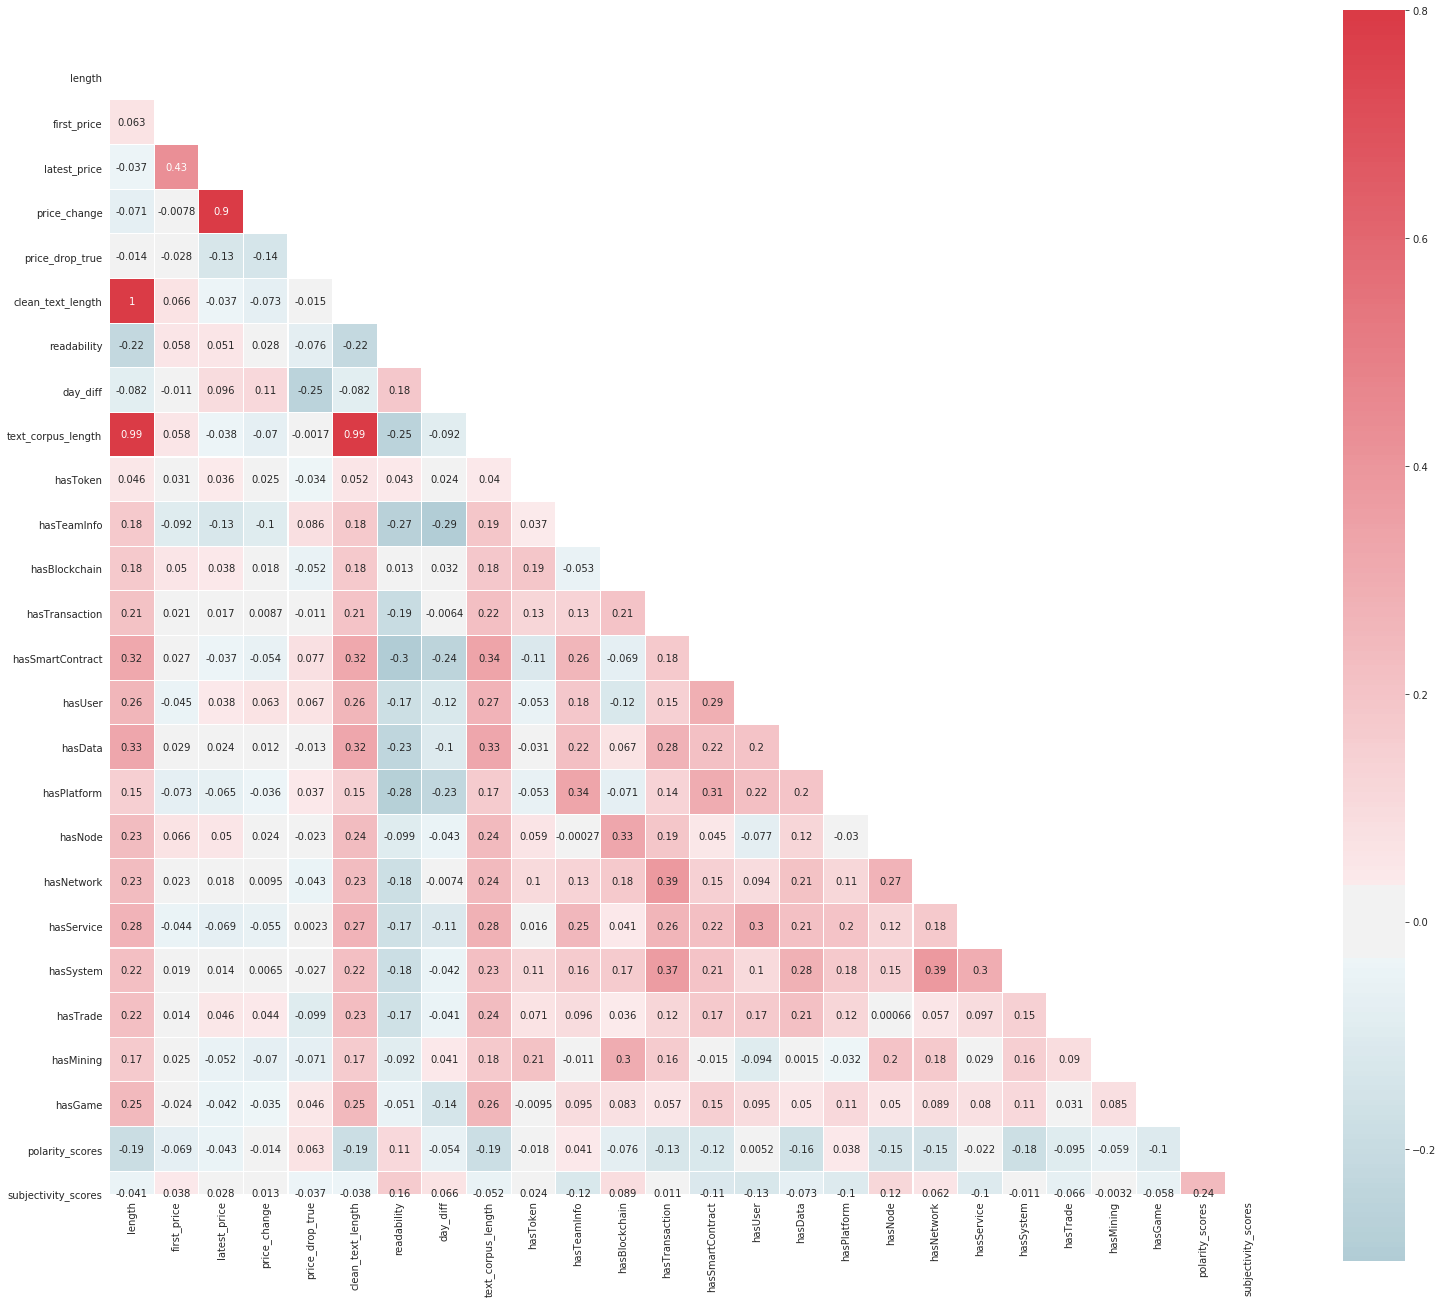

In [74]:
corr = data.corr()

mask = np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize =(26,23))

cmap = sns.diverging_palette(220,10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap , vmax = .8 ,center =0, square=True, annot = True, linewidth = .1)

In [0]:
pearsonr(data['hasNode'],data['hasTeamInfo'])

(-0.0002695531484530594, 0.9943937082579859)

In [0]:
data['clean_text2'][103]

"Whitepaper BTU [Booking Token Unit] Protocol An open protocol for decentralized bookings Vidal Chriqui, Hervé Hababou vidal@btuprotocol.com , herve@btuprotocol.com 808 Labs February 25th, 2018 Version 1.1 Abstract Our mission is to create an open source standardized decentralized booking protocol along with reference implementations that can be leveraged by participants in industries such as hospitality, travel, finance, healthcare, retail, automotive and more. is a building block for any The Booking Token Unit BTU protocol decentralized application dApp or web site willing to implement booking features for their end-users. This standard also brings interoperability among decentralized applications that incorporate it. The BTU protocol is being standardized as ERC-808 and requires the use of the Ethereum-based BTU token . The purpose of the BTU Token is to incentivize proper behaviors such as rewarding successful bookings and enforcing late cancellation and no-shows policies. All appl

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as esw

In [0]:
stopwords_cv = ['blockchain','user','data','time','use','new','coin','block','chain','smart'] + list(esw)

In [0]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='GnBu_d')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

In [0]:
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words= stopwords_cv)

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(data['clean_text3'])

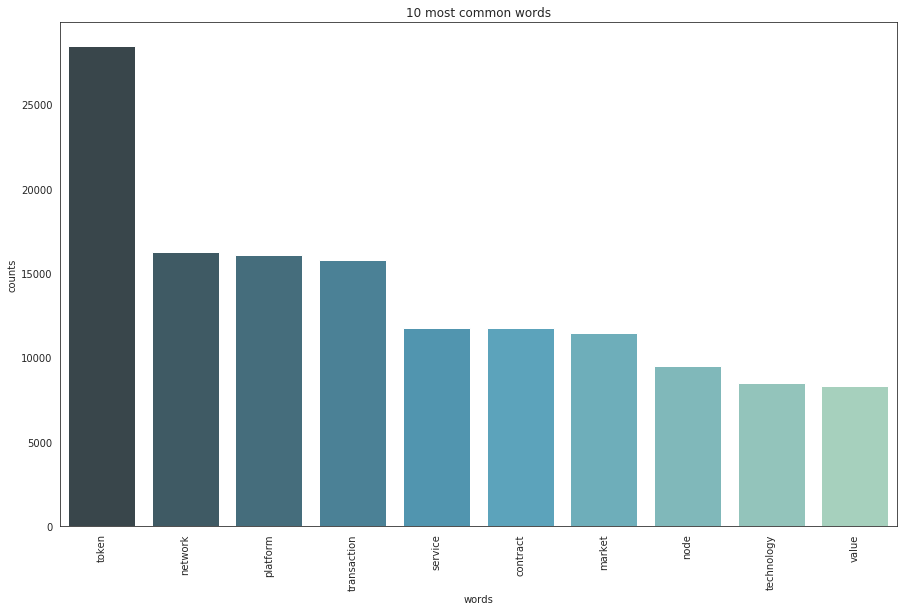

In [79]:
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [0]:
#Gensim for topic modelling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec, CoherenceModel, LdaModel, LsiModel
from pprint import pprint

In [0]:
model = Word2Vec(size = 200, window = 10, min_count = 50, sg =0,iter=15)
model.build_vocab(data['text_corpus'])

In [0]:
model.wv.vocab.keys()

dict_keys(['chain', 'consensus', 'protocol', 'jonathan', 'thomas', 'computer', 'science', 'university', 'llc', 'san', 'state', 'abstract', 'describe', 'blockchain', 'ecosystem', 'including', 'new', 'ering', 'fast', 'provide', 'proof', 'security', 'along', 'experiment', 'result', 'validating', 'e', 'ciency', 'realistic', 'network', 'condition', 'introduction', 'since', 'advent', 'bitcoin', 'world', 'cryptocurrencies', 'distributed', 'computation', 'ethereum', 'de', 'promise', 'integrating', 'turing', 'complete', 'smart', 'contract', 'building', 'application', 'dapps', 'despite', 'held', 'back', 'slow', 'time', 'example', 'transaction', 'con', 'six', 'block', 'deep', 'process', 'take', 'roughly', 'one', 'hour', 'newer', 'attempted', 'address', 'limitation', 'introducing', 'algorithm', 'faster', 'us', 'randomness', 'beacon', 'via', 'veri', 'able', 'random', 'function', 'vrf', 'ranking', 'di', 'erent', 'pro', 'designer', 'also', 'introduce', 'concept', 'notary', 'sign', 'highest', 'ranked'

In [0]:
model.wv['token']

array([-2.45127222e-03,  2.46619061e-03,  1.21464371e-03, -1.68557593e-03,
       -1.40171929e-03,  2.21377751e-03,  1.36088973e-04,  1.26208365e-03,
       -3.33765202e-04,  1.67854608e-03, -7.81562820e-04, -1.21413718e-03,
        1.57601712e-03,  1.98417204e-03, -2.05445220e-03, -5.52335929e-04,
       -9.33555944e-04,  2.31644860e-03,  2.19111051e-03, -6.08284783e-04,
       -7.03337195e-04,  1.23393617e-03, -3.17765865e-04, -2.42313044e-03,
       -6.23470813e-04,  1.41282892e-03,  1.38253579e-03, -1.56122100e-04,
        1.06017059e-03, -7.66712532e-04,  6.56225311e-04, -1.01101090e-04,
       -6.86821295e-04,  1.46619254e-03, -9.71426954e-04,  2.23953906e-03,
       -7.49432133e-04, -1.87706598e-03, -8.39151500e-04, -1.99813140e-03,
        1.78887160e-03, -6.12395088e-05, -2.48179794e-03,  2.20111237e-04,
        2.42930674e-03, -1.80875545e-03, -1.70737563e-03,  1.90864317e-03,
        2.05900986e-03,  4.11531160e-04,  1.57040148e-03, -1.43474061e-03,
        1.14391069e-03, -

In [0]:
from sklearn.manifold import TSNE

In [0]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=100)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

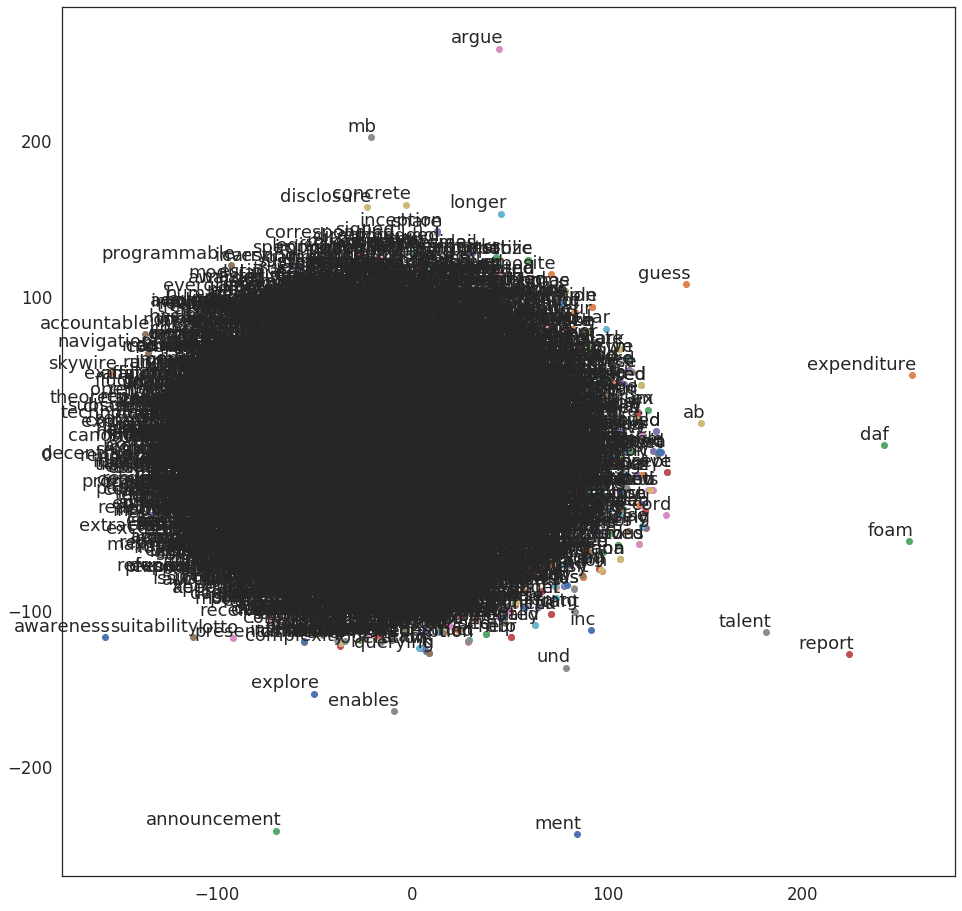

In [0]:
import warnings
warnings.filterwarnings('ignore')
tsne_plot(model)

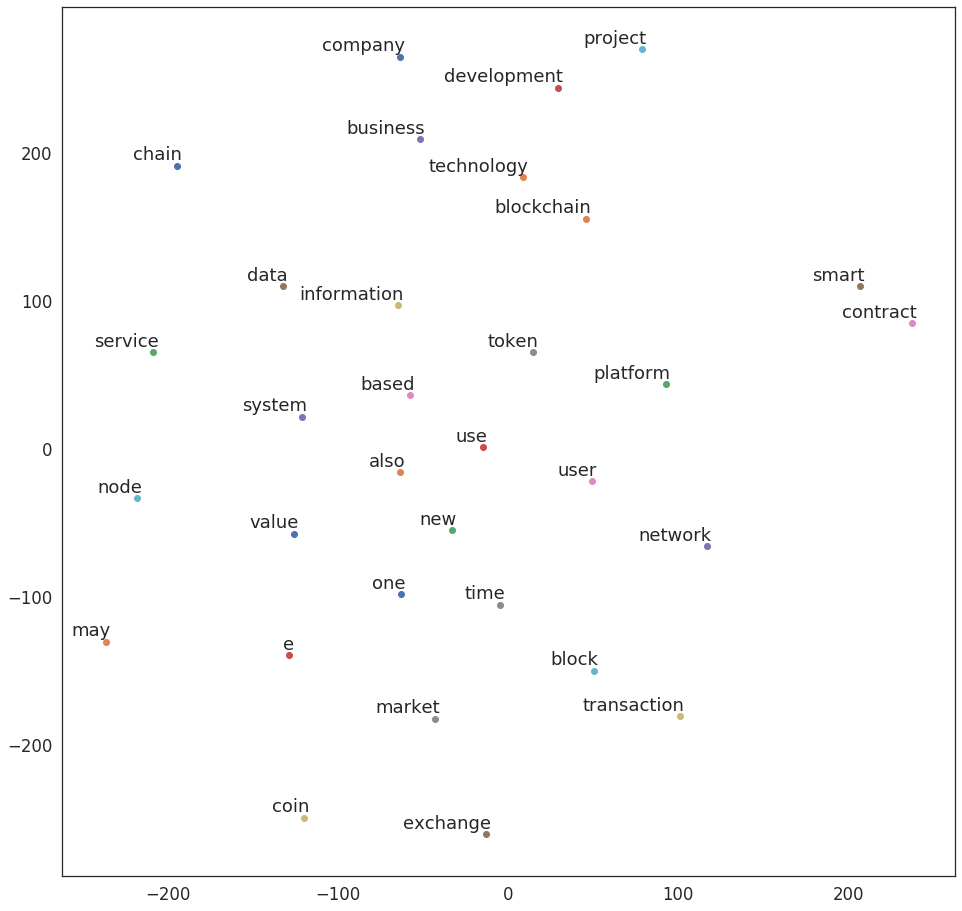

In [0]:
# A more selective model
model = Word2Vec(list_words,size=200, window=20, min_count=7000, workers=4)
tsne_plot(model)

In [0]:
model.corpus_count

713

In [0]:
model.wv.most_similar('blockchain')

[('technology', 0.7675803899765015),
 ('development', 0.31495484709739685),
 ('business', 0.2686936855316162),
 ('based', 0.23508159816265106),
 ('chain', 0.22096696496009827),
 ('smart', 0.20164497196674347),
 ('transaction', 0.1663188636302948),
 ('project', 0.15835723280906677),
 ('block', 0.06646701693534851),
 ('contract', 0.04703433811664581)]

In [0]:
model.wv.most_similar('coin')

[('transaction', 0.29086434841156006),
 ('block', 0.28201186656951904),
 ('exchange', 0.2782658338546753),
 ('new', 0.20608118176460266),
 ('one', 0.10430850088596344),
 ('time', 0.07499631494283676),
 ('value', 0.07374729216098785),
 ('project', 0.048496708273887634),
 ('e', 0.01584944874048233),
 ('development', 0.008470707572996616)]

In [0]:
from gensim.parsing.preprocessing import STOPWORDS

In [0]:
dictionary = gensim.corpora.Dictionary(data['text_corpus'])

In [0]:
#Filter out words that occur less than 100 whitepapers
dictionary.filter_extremes(no_below=100,no_above=0.6)
print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 1884


In [0]:
#Transforming corpus into bag of words vectors

bow_corpus = [dictionary.doc2bow(doc) for doc in data['text_corpus']]
print(bow_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 4), (5, 1), (6, 1), (7, 33), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 2), (14, 1), (15, 3), (16, 1), (17, 1), (18, 1), (19, 1), (20, 4), (21, 1), (22, 1), (23, 1), (24, 1), (25, 4), (26, 3), (27, 5), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 3), (34, 1), (35, 4), (36, 1), (37, 12), (38, 1), (39, 2), (40, 1), (41, 2), (42, 10), (43, 26), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 2), (53, 17), (54, 4), (55, 2), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 3), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 3), (74, 1), (75, 2), (76, 3), (77, 1), (78, 1), (79, 1), (80, 1), (81, 4), (82, 1), (83, 4), (84, 2), (85, 1), (86, 1), (87, 3), (88, 2), (89, 1), (90, 5), (91, 1), (92, 2), (93, 2), (94, 1), (95, 3), (96, 3), (97, 2), (98, 3), (99, 1), (100, 3), (101, 7), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 3), (109, 1), (11

In [0]:
# Human readable format of corpus (term-frequency)
print([[(dictionary[id], freq) for id, freq in cp] for cp in bow_corpus[:1]])

[[('abstract', 1), ('accepted', 1), ('acquire', 1), ('across', 1), ('act', 4), ('acting', 1), ('action', 1), ('active', 33), ('added', 1), ('adding', 1), ('adjust', 1), ('agreement', 2), ('along', 1), ('although', 2), ('always', 1), ('among', 3), ('analysis', 1), ('annual', 1), ('anyone', 1), ('apply', 1), ('approach', 4), ('arbitrary', 1), ('architecture', 1), ('ask', 1), ('assigned', 1), ('assume', 4), ('assumption', 3), ('attacker', 5), ('attempt', 1), ('author', 1), ('aware', 2), ('basis', 1), ('becomes', 1), ('begin', 3), ('beginning', 1), ('bound', 4), ('cash', 1), ('cation', 12), ('center', 1), ('chance', 2), ('changed', 1), ('choosing', 2), ('chosen', 10), ('client', 26), ('collection', 1), ('communication', 1), ('computation', 1), ('computational', 1), ('computer', 1), ('computing', 1), ('con', 2), ('concept', 1), ('condition', 2), ('consensus', 17), ('consider', 4), ('considered', 2), ('consistent', 2), ('consists', 1), ('constitute', 1), ('containing', 1), ('continue', 1), (

In [0]:
print('Total number of whitepapers:', len(bow_corpus))

Total number of whitepapers: 684


In [0]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = bow_corpus, id2word = dictionary, num_topics = 10, random_state =42, update_every = 1,
                                            chunksize=200,passes=10,alpha='auto',per_word_topics=True)

In [0]:
pprint(lda_model.print_topics())

[(0,
  '0.057*"game" + 0.029*"player" + 0.028*"trading" + 0.018*"trader" + '
  '0.015*"gaming" + 0.011*"virtual" + 0.011*"investor" + 0.008*"win" + '
  '0.007*"play" + 0.007*"trade"'),
 (1,
  '0.019*"node" + 0.014*"hash" + 0.013*"miner" + 0.011*"mining" + '
  '0.011*"signature" + 0.010*"output" + 0.009*"x" + 0.008*"size" + '
  '0.007*"scheme" + 0.007*"attack"'),
 (2,
  '0.020*"vote" + 0.017*"creator" + 0.016*"voting" + 0.009*"governance" + '
  '0.009*"dapp" + 0.008*"proposal" + 0.008*"incentive" + 0.008*"rating" + '
  '0.007*"pool" + 0.007*"review"'),
 (3,
  '0.015*"trade" + 0.013*"gold" + 0.013*"liquidity" + 0.013*"buyer" + '
  '0.012*"agent" + 0.012*"provider" + 0.010*"loan" + 0.010*"seller" + '
  '0.008*"reserve" + 0.007*"marketplace"'),
 (4,
  '0.018*"ico" + 0.008*"io" + 0.007*"page" + 0.007*"card" + 0.006*"customer" + '
  '0.006*"investor" + 0.005*"btc" + 0.005*"white" + 0.005*"mobile" + '
  '0.004*"release"'),
 (5,
  '0.040*"node" + 0.012*"consensus" + 0.009*"layer" + 0.007*"devi

In [0]:
# Compute Perplexity
print('\nPerplexity:', lda_model.log_perplexity(bow_corpus))

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts = data['text_corpus'], dictionary = dictionary, coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score:', coherence_lda)


Perplexity: -7.098809484921261

Coherence Score: 0.4777985388663959


In [80]:
data.shape

(682, 35)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error

In [0]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
import xgboost
import lightgbm

In [0]:
import statsmodels.api as sm
import scipy.stats as st
from statsmodels.tools import add_constant as add_constant

In [83]:
data.columns

Index(['coin', 'text', 'length', 'coin_id', 'first_date', 'first_price',
       'latest_date [9/9/19]', 'latest_price', 'price_change',
       'price_drop_true', 'clean_text', 'clean_text_length', 'clean_text2',
       'readability', 'clean_text3', 'day_diff', 'text_corpus',
       'text_corpus_length', 'hasToken', 'hasTeamInfo', 'hasBlockchain',
       'hasTransaction', 'hasSmartContract', 'hasUser', 'hasData',
       'hasPlatform', 'hasNode', 'hasNetwork', 'hasService', 'hasSystem',
       'hasTrade', 'hasMining', 'hasGame', 'polarity_scores',
       'subjectivity_scores'],
      dtype='object')

In [84]:
data.isnull().sum()

coin                    0
text                    0
length                  0
coin_id                 0
first_date              0
first_price             0
latest_date [9/9/19]    0
latest_price            0
price_change            0
price_drop_true         0
clean_text              0
clean_text_length       0
clean_text2             0
readability             0
clean_text3             0
day_diff                0
text_corpus             0
text_corpus_length      0
hasToken                0
hasTeamInfo             0
hasBlockchain           0
hasTransaction          0
hasSmartContract        0
hasUser                 0
hasData                 0
hasPlatform             0
hasNode                 0
hasNetwork              0
hasService              0
hasSystem               0
hasTrade                0
hasMining               0
hasGame                 0
polarity_scores         0
subjectivity_scores     0
dtype: int64

In [92]:
data1 = data[['first_price','day_diff','hasBlockchain','hasUser','hasTeamInfo','hasSmartContract','hasNode','hasNetwork','hasPlatform','hasData'
              ,'hasSystem','hasTransaction','hasService','hasGame','hasToken','hasTrade','hasMining',
              'polarity_scores','subjectivity_scores','readability','price_drop_true']]

data1.head()

,first_price,day_diff,hasBlockchain,hasUser,hasTeamInfo,hasSmartContract,hasNode,hasNetwork,hasPlatform,hasData,hasSystem,hasTransaction,hasService,hasGame,hasToken,hasTrade,hasMining,polarity_scores,subjectivity_scores,readability,price_drop_true
0,0.483325,417,1,0,0,1,1,1,1,0,1,1,1,0,1,0,1,0.045996,0.501959,54.86,1
1,0.220802,692,1,1,0,1,1,1,0,1,1,1,1,1,1,1,0,0.094660,0.458596,38.15,1
2,0.043637,424,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0.120486,0.442333,36.02,1
3,5.741111,193,0,1,1,0,0,0,0,1,0,1,1,0,0,1,0,0.139106,0.392216,47.72,1
4,8.511169,313,1,0,1,0,1,1,1,0,1,1,1,1,1,0,1,0.117985,0.407594,32.74,1


In [93]:
data1_constant = add_constant(data1)
data1_constant.head()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,first_price,day_diff,hasBlockchain,hasUser,hasTeamInfo,hasSmartContract,hasNode,hasNetwork,hasPlatform,hasData,hasSystem,hasTransaction,hasService,hasGame,hasToken,hasTrade,hasMining,polarity_scores,subjectivity_scores,readability,price_drop_true
0,1.0,0.483325,417,1,0,0,1,1,1,1,0,1,1,1,0,1,0,1,0.045996,0.501959,54.86,1
1,1.0,0.220802,692,1,1,0,1,1,1,0,1,1,1,1,1,1,1,0,0.094660,0.458596,38.15,1
2,1.0,0.043637,424,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0.120486,0.442333,36.02,1
3,1.0,5.741111,193,0,1,1,0,0,0,0,1,0,1,1,0,0,1,0,0.139106,0.392216,47.72,1
4,1.0,8.511169,313,1,0,1,0,1,1,1,0,1,1,1,1,1,0,1,0.117985,0.407594,32.74,1


In [94]:
data1_constant.columns[:-1]

Index(['const', 'first_price', 'day_diff', 'hasBlockchain', 'hasUser',
       'hasTeamInfo', 'hasSmartContract', 'hasNode', 'hasNetwork',
       'hasPlatform', 'hasData', 'hasSystem', 'hasTransaction', 'hasService',
       'hasGame', 'hasToken', 'hasTrade', 'hasMining', 'polarity_scores',
       'subjectivity_scores', 'readability'],
      dtype='object')

In [109]:
st.chisqprob = lambda chisq, df: st.chi2.sf(chisq, df)
cols = data1_constant.columns[:-1]
model=sm.Logit(data1.price_drop_true,data1_constant[cols])
result=model.fit(method='newton')
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.395612
         Iterations 7
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.089     
Dependent Variable:   price_drop_true  AIC:              581.6148  
Date:                 2019-11-24 02:52 BIC:              676.6405  
No. Observations:     682              Log-Likelihood:   -269.81   
Df Model:             20               LL-Null:          -296.31   
Df Residuals:         661              LLR p-value:      8.0869e-05
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       7.0000                                       
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
const                4.8764   1.6853  2.8935 0.0038  1.5733  8.1796
first_price         -0.0002   0.0004 -0.5

Level Significance 0.9 
Y = 4.8764 - 0.0012*day_diff - 0.6855*hasTrade 

In [162]:
data2 = data[['latest_price','day_diff', 'hasUser','hasPlatform'
              ,'hasService','hasTrade','hasMining',
              'polarity_scores','readability','price_drop_true']]
data2.head()

,latest_price,day_diff,hasUser,hasPlatform,hasService,hasTrade,hasMining,polarity_scores,readability,price_drop_true
0,0.037275,417,0,1,1,0,1,0.045996,54.86,1
1,0.161849,692,1,0,1,1,0,0.094660,38.15,1
2,0.001059,424,1,1,1,1,1,0.120486,36.02,1
3,3.430866,193,1,0,1,1,0,0.139106,47.72,1
4,0.088748,313,0,1,1,0,1,0.117985,32.74,1


In [163]:
data2_constant = add_constant(data2)
data2_constant.head()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,latest_price,day_diff,hasUser,hasPlatform,hasService,hasTrade,hasMining,polarity_scores,readability,price_drop_true
0,1.0,0.037275,417,0,1,1,0,1,0.045996,54.86,1
1,1.0,0.161849,692,1,0,1,1,0,0.094660,38.15,1
2,1.0,0.001059,424,1,1,1,1,1,0.120486,36.02,1
3,1.0,3.430866,193,1,0,1,1,0,0.139106,47.72,1
4,1.0,0.088748,313,0,1,1,0,1,0.117985,32.74,1


In [164]:
data2_constant.columns[:-1]

Index(['const', 'latest_price', 'day_diff', 'hasUser', 'hasPlatform',
       'hasService', 'hasTrade', 'hasMining', 'polarity_scores',
       'readability'],
      dtype='object')

In [179]:
st.chisqprob = lambda chisq, df: st.chi2.sf(chisq, df)
cols = data2_constant.columns[:-1]
model=sm.Logit(data2.price_drop_true,data2_constant[cols])
result=model.fit(method='newton')
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.391277
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.099     
Dependent Variable: price_drop_true  AIC:              553.7022  
Date:               2019-11-24 04:14 BIC:              598.9525  
No. Observations:   682              Log-Likelihood:   -266.85   
Df Model:           9                LL-Null:          -296.31   
Df Residuals:       672              LLR p-value:      2.1567e-09
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const              4.1783   0.9995  4.1805 0.0000  2.2194  6.1373
latest_price      -0.0021   0.0013 -1.6014 0.1093 -0.0047  0.0005


In [204]:
data3 = data[['day_diff','hasTrade','polarity_scores','readability','price_drop_true']]
data3.head()

,day_diff,hasTrade,polarity_scores,readability,price_drop_true
0,417,0,0.045996,54.86,1
1,692,1,0.094660,38.15,1
2,424,1,0.120486,36.02,1
3,193,1,0.139106,47.72,1
4,313,0,0.117985,32.74,1


In [205]:
data3_constant = add_constant(data3)
data3_constant.head()

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,day_diff,hasTrade,polarity_scores,readability,price_drop_true
0,1.0,417,0,0.045996,54.86,1
1,1.0,692,1,0.094660,38.15,1
2,1.0,424,1,0.120486,36.02,1
3,1.0,193,1,0.139106,47.72,1
4,1.0,313,0,0.117985,32.74,1


In [206]:
st.chisqprob = lambda chisq, df: st.chi2.sf(chisq, df)
cols = data3_constant.columns[:-1]
model=sm.Logit(data3.price_drop_true,data3_constant[cols])
result=model.fit(method='minimize')
print(result.summary2())

         Current function value: 0.401550
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 39
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.076     
Dependent Variable: price_drop_true  AIC:              557.7138  
Date:               2019-11-24 04:39 BIC:              580.3389  
No. Observations:   682              Log-Likelihood:   -273.86   
Df Model:           4                LL-Null:          -296.31   
Df Residuals:       677              LLR p-value:      4.1396e-09
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const              3.1607   0.7338  4.3073 0.0000  1.7225  4.5989
day_diff          -0.0013   0.0002

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [112]:
X['day_diff'].describe()

count     682.000000
mean      555.171554
std       391.115253
min        39.000000
25%       344.250000
50%       474.500000
75%       644.000000
max      2325.000000
Name: day_diff, dtype: float64

In [117]:
pd.crosstab(X['hasTrade'],y['price_drop_true'])

price_drop_true,0,1
hasTrade,,
0,36,271
1,71,304


UsageError: %%latex is a cell magic, but the cell body is empty.


In [194]:
X = data[['day_diff','hasTrade', 'hasMining',
              'polarity_scores','readability']]

X.head()

,day_diff,hasTrade,hasMining,polarity_scores,readability
0,417,0,1,0.045996,54.86
1,692,1,0,0.094660,38.15
2,424,1,1,0.120486,36.02
3,193,1,0,0.139106,47.72
4,313,0,1,0.117985,32.74


In [185]:
y = data[['price_drop_true']]
y.head()

,price_drop_true
0,1
1,1
2,1
3,1
4,1


In [186]:
y['price_drop_true'].value_counts()

1    575
0    107
Name: price_drop_true, dtype: int64

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 42, stratify = y)

In [0]:
#Using Count Vectorizer 
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [196]:
lm = LogisticRegression(solver='lbfgs')
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
score = lm.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.8540145985401459


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [197]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.19      0.29        21
           1       0.87      0.97      0.92       116

    accuracy                           0.85       137
   macro avg       0.72      0.58      0.60       137
weighted avg       0.82      0.85      0.82       137



In [107]:
print(confusion_matrix(y_test,y_pred))

[[  2  19]
 [  4 112]]


In [0]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=42,
                                           chunksize=100,
                                           passes=20,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts= list_words, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [0]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus= bow_corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=list_words, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

In [0]:
import time

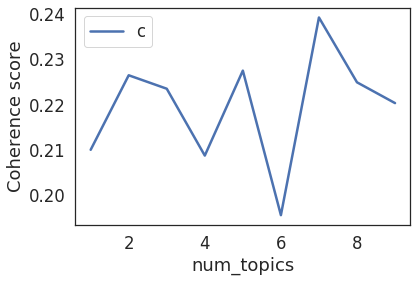

CPU times: user 6min 9s, sys: 5.52 s, total: 6min 14s
Wall time: 6min 8s


In [0]:
%%time
import warnings
warnings.filterwarnings('ignore')
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=bow_corpus, texts=list_words, limit=10)

In [0]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 8.6MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=c6de0e0f37d40a0ef4c62d64d5b81afbabd1cb9e040211e3b90c211e8093581d
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [0]:
import pyLDAvis
import pyLDAvis.gensim

In [0]:
pyLDAvis.gensim.prepare(lmlist[2], bow_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.006532  0.000960       1        1  37.265240
1      0.002223 -0.004985       2        1  31.928257
2      0.004309  0.004025       3        1  30.806503, topic_info=     Category         Freq       Term        Total  loglift  logprob
188   Default  3499.000000          n  3499.000000  30.0000  30.0000
471   Default  3897.000000       game  3897.000000  29.0000  29.0000
855   Default  1760.000000     energy  1760.000000  28.0000  28.0000
182   Default  2350.000000      miner  2350.000000  27.0000  27.0000
492   Default  1933.000000  incentive  1933.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
961    Topic3   810.141541        ico  3625.911621  -0.3212  -6.0000
204    Topic3   709.589111       page  2381.720459  -0.0334  -6.1325
52     Topic3   781.689209  consensus  3467.260254  -0.3122  -6.03

##LSI Model (Alternative form LSA model)

In [0]:
lsi_model = LsiModel(corpus = bow_corpus, num_topics = 10, id2word = dictionary)

In [0]:
lsi_model.show_topics(num_topics=20)

[(0,
  '0.153*"n" + 0.150*"p" + 0.125*"consensus" + 0.116*"r" + 0.108*"game" + 0.102*"customer" + 0.102*"x" + 0.100*"hash" + 0.100*"trading" + 0.098*"client"'),
 (1,
  '-0.442*"n" + -0.331*"r" + -0.230*"h" + -0.211*"l" + -0.204*"p" + -0.124*"k" + 0.119*"customer" + -0.115*"f" + 0.114*"energy" + -0.114*"miner"'),
 (2,
  '0.834*"energy" + -0.365*"game" + 0.148*"green" + -0.145*"player" + 0.111*"customer" + 0.089*"consumer" + -0.079*"gaming" + -0.069*"video" + -0.068*"advertising" + 0.062*"utility"'),
 (3,
  '0.458*"game" + 0.347*"n" + 0.254*"r" + 0.214*"player" + 0.198*"energy" + -0.190*"consensus" + 0.155*"h" + -0.154*"hash" + -0.140*"storage" + 0.136*"l"'),
 (4,
  '-0.572*"game" + -0.347*"energy" + 0.207*"merchant" + -0.203*"player" + -0.200*"miner" + 0.192*"r" + 0.169*"n" + 0.126*"consumer" + 0.121*"customer" + -0.121*"hash"'),
 (5,
  '0.727*"merchant" + 0.205*"consumer" + 0.204*"customer" + -0.166*"trading" + -0.155*"ico" + 0.148*"score" + -0.142*"investor" + 0.142*"game" + 0.139*"di

In [0]:
import operator

In [0]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    top_topics = [(0, 0)]
    while top_topics[0][1] < 0.97:
        lm = LdaModel(corpus= bow_corpus, id2word=dictionary)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=list_words, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics

In [0]:
import warnings
warnings.simplefilter('ignore')
lm, top_topics = ret_top_model()

In [0]:
import pyLDAvis
import pyLDAvis.gensim

In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model,bow_corpus,dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.164779 -0.072245       1        1  15.770536
2      0.002254 -0.047141       2        1  15.359031
0     -0.096588 -0.002560       3        1  13.616283
8     -0.024032 -0.047089       4        1  13.287801
9     -0.081234  0.009542       5        1  11.808408
5      0.036138 -0.078371       6        1   8.519567
4      0.254181  0.097108       7        1   8.151798
6     -0.082053 -0.055524       8        1   5.868786
1     -0.093102 -0.060354       9        1   4.679011
7     -0.080343  0.256633      10        1   2.938781, topic_info=     Category         Freq      Term        Total  loglift  logprob
471   Default  3840.000000      game  3840.000000  30.0000  30.0000
557   Default  4300.000000         p  4300.000000  29.0000  29.0000
188   Default  3074.000000         n  3074.000000  28.0000  28.0000
1299  Default  2116.000000  merchant  2116.000000  27.0000  27.0000
235   Default  2581.000000         r  2581.000000  26.0000  26.0000
...       ...          ...       ...          ...      ...      ...
86    Topic10   204.447250  document  2001.380981   1.2459  -5.0272
803   Topic10   187.287018    credit  1815.101685   1.2559  -5.1148
757   Topic10   160.566055        co  1402.962524   1.3595  -5.2688
355   Topic10   193.465958       app  2248.359863   1.0743  -5.0824
922   Topic10   158.659546   founder  1965.883179   1.0102  -5.2807

[544 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
653       1  0.133468  accept
653       2  0.150994  accept
653       3  0.057971  accept
653       4  0.117290  accept
653       5  0.113245  accept
...     ...       ...     ...
1867      5  0.007677       z
1867      6  0.033779       z
1867      7  0.644866       z
1867      9  0.001535       z
1867     10  0.049133       z

[3391 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 9, 10, 6, 5, 7, 2, 8])

In [0]:
ldatopics = lda_model.show_topics(formatted=False)
ldatopics

[(0,
  [('energy', 0.01752108),
   ('customer', 0.012832063),
   ('page', 0.0078082345),
   ('consumer', 0.006955072),
   ('founder', 0.0068403473),
   ('partner', 0.0064137825),
   ('app', 0.005910672),
   ('mobile', 0.0057476377),
   ('country', 0.0052743857),
   ('advisor', 0.0048297625)]),
 (1,
  [('game', 0.073571004),
   ('player', 0.037350994),
   ('gaming', 0.018950757),
   ('virtual', 0.0156160155),
   ('win', 0.010671271),
   ('play', 0.009838861),
   ('mobile', 0.0080146305),
   ('winning', 0.007133315),
   ('revenue', 0.0064971857),
   ('talent', 0.0062997583)]),
 (2,
  [('ico', 0.007989714),
   ('trading', 0.007347285),
   ('btc', 0.0062589357),
   ('liquidity', 0.0051322803),
   ('trade', 0.005028015),
   ('option', 0.0047444394),
   ('stake', 0.004678975),
   ('staking', 0.0045871064),
   ('investor', 0.0045077926),
   ('fiat', 0.004474715)]),
 (3,
  [('mining', 0.01562204),
   ('consensus', 0.0151407635),
   ('hash', 0.014412),
   ('miner', 0.011293355),
   ('signature'

In [0]:
from gensim.models import HdpModel

In [0]:
hdpmodel = HdpModel(corpus=bow_corpus, id2word=dictionary)
hdpmodel.show_topics()

[(0,
  '0.004*ico + 0.004*p + 0.004*trading + 0.004*game + 0.003*customer + 0.003*investor + 0.003*client + 0.003*foundation + 0.003*consumer + 0.003*provider + 0.003*mobile + 0.003*app + 0.003*mining + 0.003*n + 0.002*consensus + 0.002*white + 0.002*g + 0.002*page + 0.002*energy + 0.002*x'),
 (1,
  '0.007*consensus + 0.007*hash + 0.007*n + 0.006*p + 0.006*r + 0.005*signature + 0.005*x + 0.004*ledger + 0.004*message + 0.004*l + 0.004*attack + 0.004*h + 0.004*output + 0.004*miner + 0.003*de + 0.003*game + 0.003*layer + 0.003*di + 0.003*f + 0.003*k'),
 (2,
  '0.005*customer + 0.004*apis + 0.004*bit + 0.004*merchant + 0.004*domain + 0.004*loan + 0.004*ico + 0.003*school + 0.003*miner + 0.003*identity + 0.003*tax + 0.003*app + 0.003*org + 0.003*intelligence + 0.003*report + 0.003*mobile + 0.003*document + 0.003*trading + 0.003*provider + 0.003*adoption'),
 (3,
  '0.008*n + 0.007*merchant + 0.005*signature + 0.005*h + 0.004*r + 0.004*consumer + 0.004*x + 0.003*p + 0.003*economic + 0.003*min

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(data['clean_text3']).toarray()
y = data['price_drop_true'].values

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [0]:
from sklearn.naive_bayes import BernoulliNB
classifier = BernoulliNB()
classifier.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [0]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [0]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[  0  21]
 [  2 114]]


In [0]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.98      0.84      0.91       135

    accuracy                           0.83       137
   macro avg       0.49      0.42      0.45       137
weighted avg       0.97      0.83      0.90       137



In [0]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.98      0.84      0.91       135

    accuracy                           0.83       137
   macro avg       0.49      0.42      0.45       137
weighted avg       0.97      0.83      0.90       137



In [0]:
from sklearn.metrics import roc_auc_score, roc_curve
bnb_auc = roc_auc_score(y_test , y_pred)
print('AUC: %.3f' % bnb_auc)

AUC: 0.491


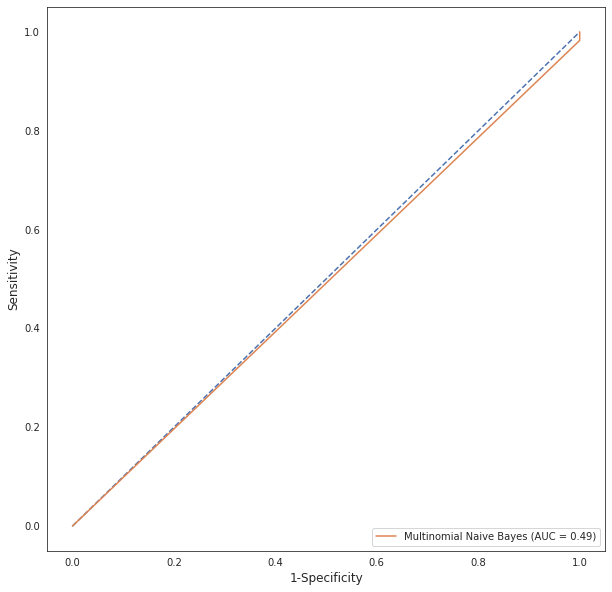

In [0]:
fpr, tpr , thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(10,10))
plt.plot([0,1],[0,1],linestyle="--")
plt.plot(fpr,tpr, label='Multinomial Naive Bayes (AUC = %0.2f)'% bnb_auc)
plt.xlabel("1-Specificity",fontsize=12)
plt.ylabel("Sensitivity",fontsize=12)
plt.legend(loc='lower right')
plt.show()